In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt
import emlddmm
import numpy as np
import torch
import json
import os
import transformation_graph_v01 as tg
import importlib
import pickle
import tifffile as tf

In [ ]:
reg_list = [
    {
        'registration': [['nissl','hua141'], ['fluoro', 'hua141']],
        'source': '/home/brysongray/data/csh_data/mouse_data/nissl',
        'target': '/home/brysongray/data/csh_data/mouse_data/fluoro',
        'config': '/home/brysongray/data/csh_data/mouse_data/configHUA141_nissl_to_fluoro.json',
        'output': '/home/brysongray/data/csh_data/mouse_data/reg_outputs/'
    }
]

In [35]:
reg_list = [
    {
        'registration': [['nissl', 'm519N'], ['myelin', 'm519M']],
        'source': '/home/brysongray/data/marmoset_ccf/M519N-STIF_new/',
        'target': '/home/brysongray/data/marmoset_ccf/m519M-STIF_new/',
        'config': '/home/brysongray/data/marmoset_ccf/configM519_nissl_to_myelin.json',
        'output': '/home/brysongray/data/marmoset_ccf/nissl_to_myelin_outputs/'
    }
]

<IPython.core.display.Javascript object>


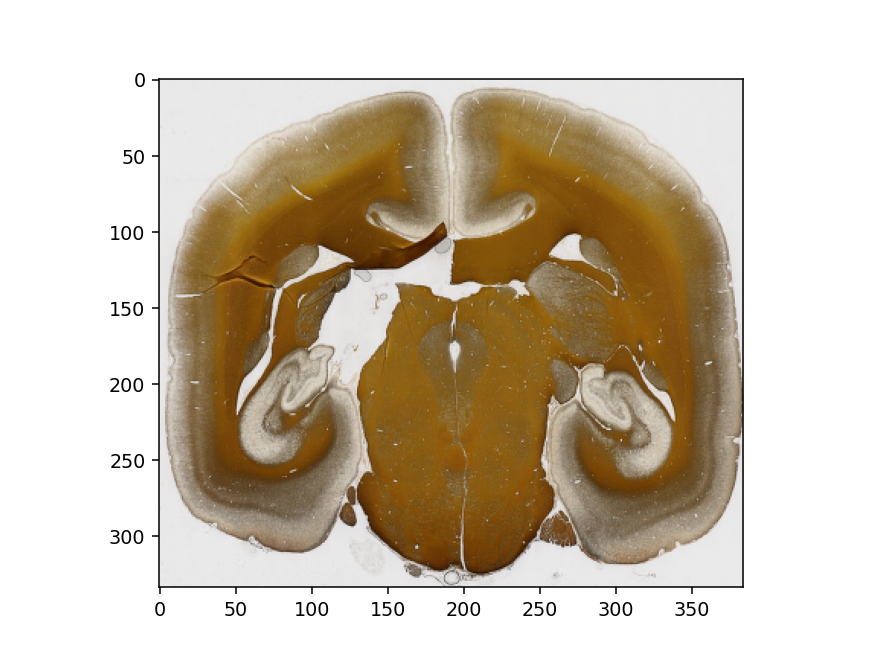

In [25]:
img_path = os.path.join(reg_list[0]['target'],'M519-M347--_1_0479.tif') 
img = plt.imread(img_path)/255.0
plt.figure()
plt.imshow(img)


registering /home/brysongray/data/marmoset_ccf/M519N-STIF_new/ to /home/brysongray/data/marmoset_ccf/m519M-STIF_new/
loading target images


<IPython.core.display.Javascript object>


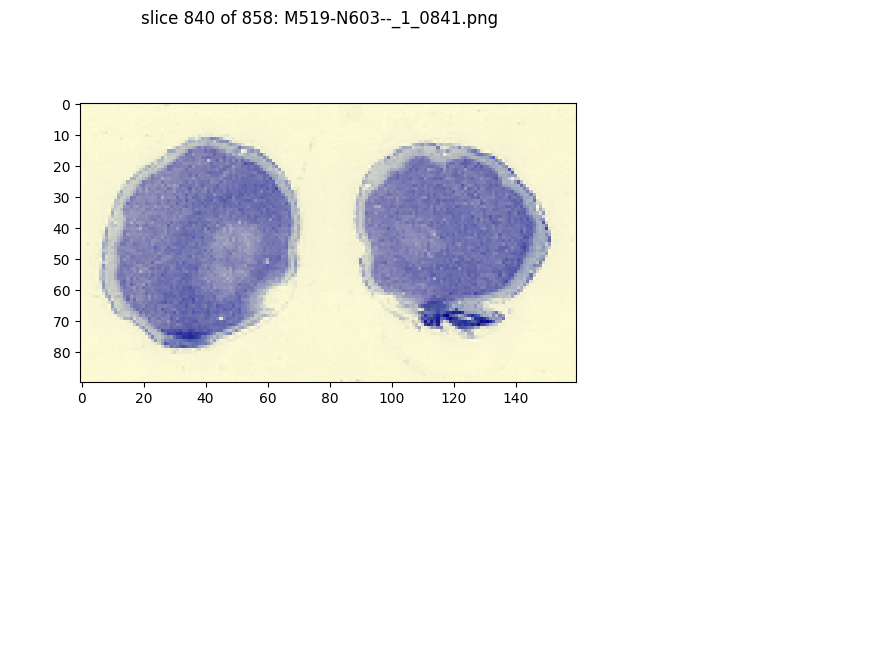

loading target images


<IPython.core.display.Javascript object>


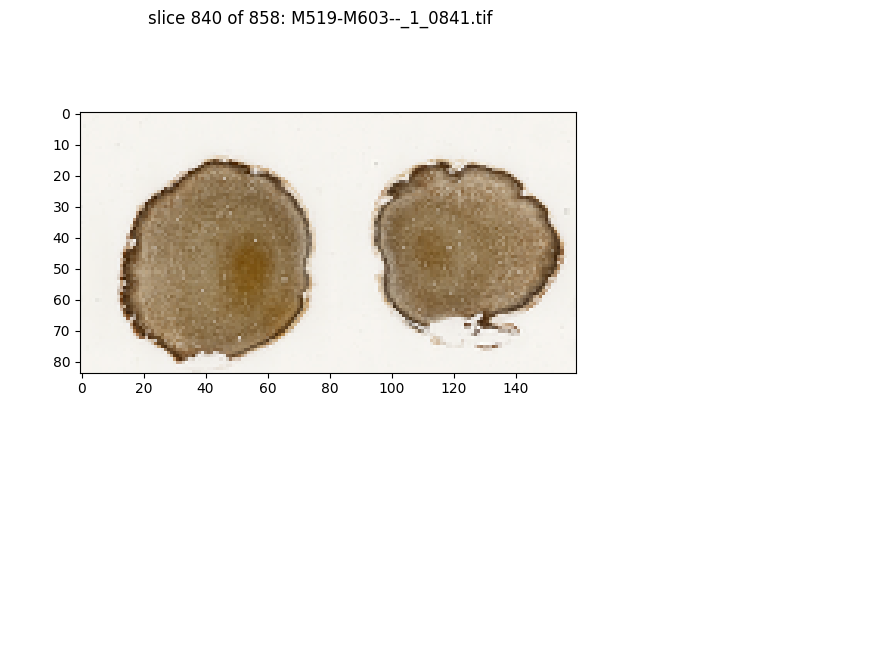

Found 1 scales


<IPython.core.display.Javascript object>


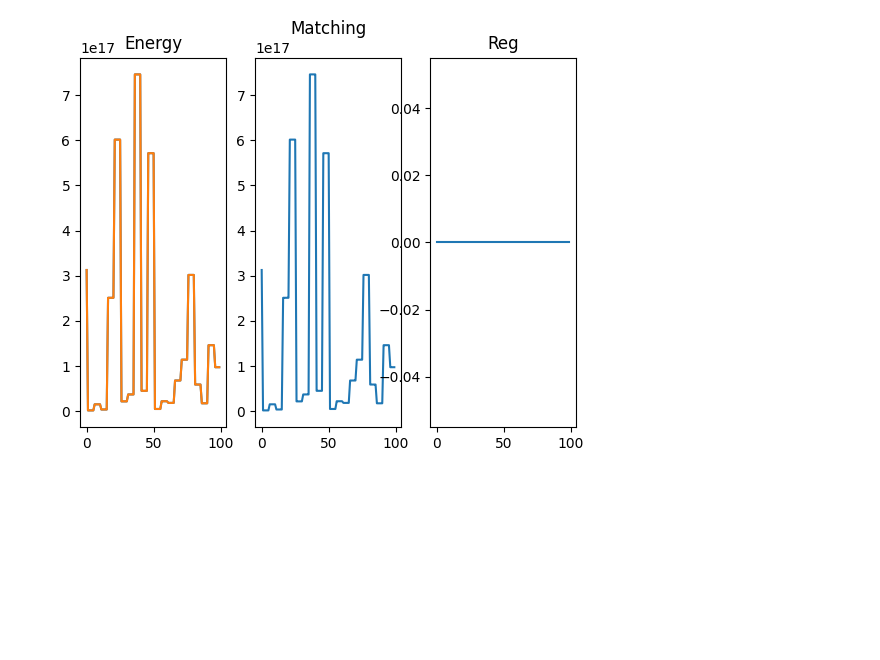

<IPython.core.display.Javascript object>


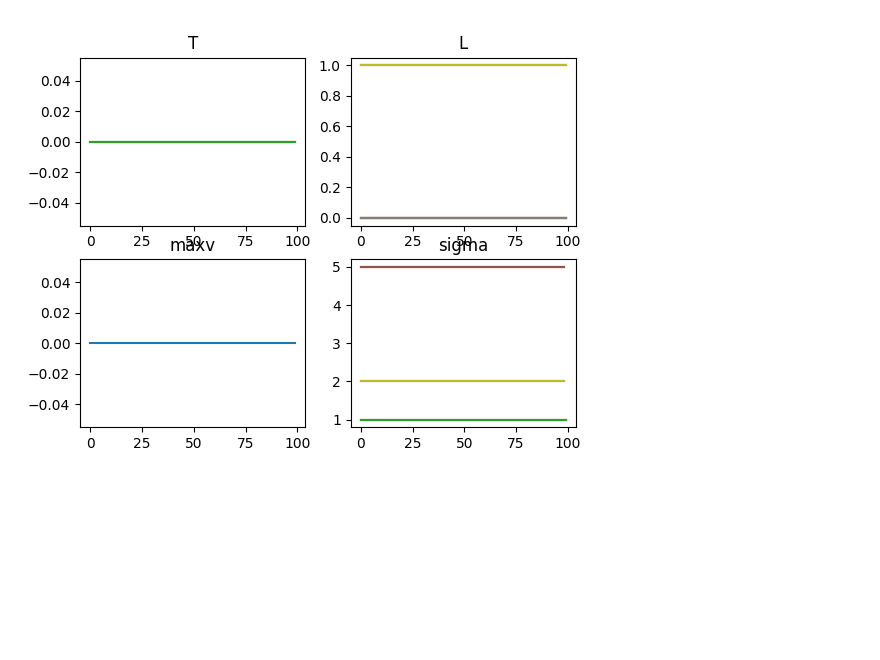

<IPython.core.display.Javascript object>


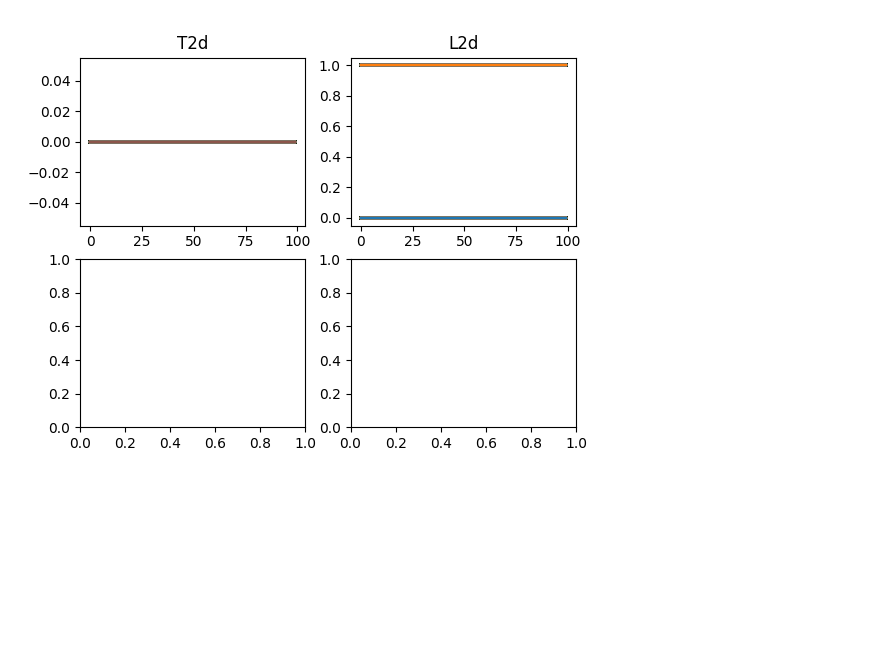

<IPython.core.display.Javascript object>


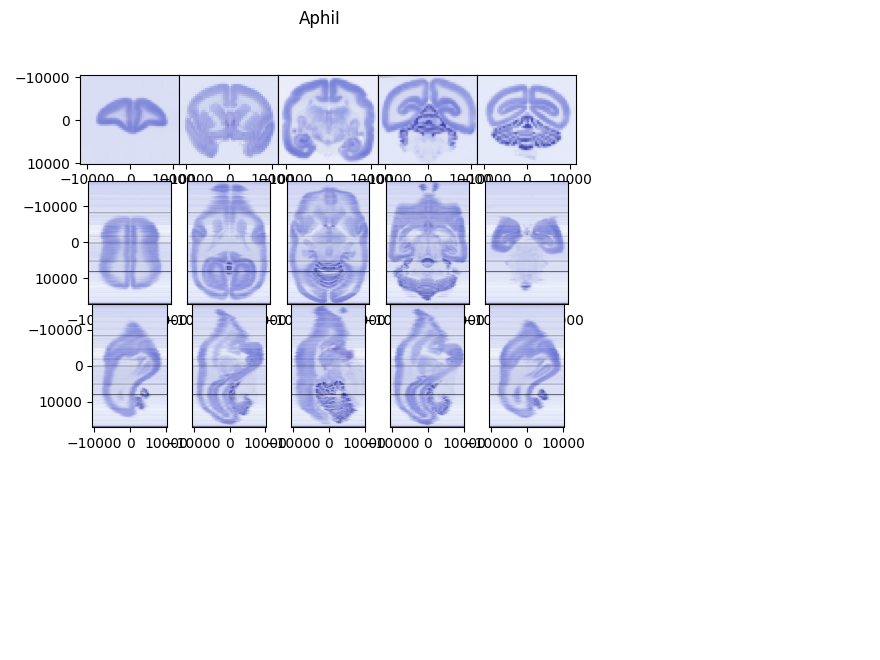

<IPython.core.display.Javascript object>


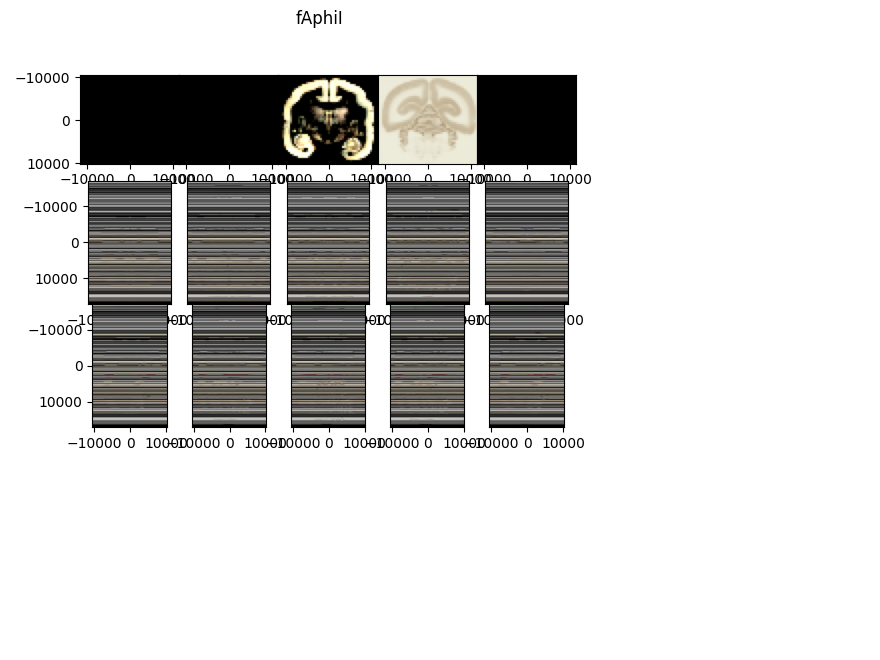

<IPython.core.display.Javascript object>


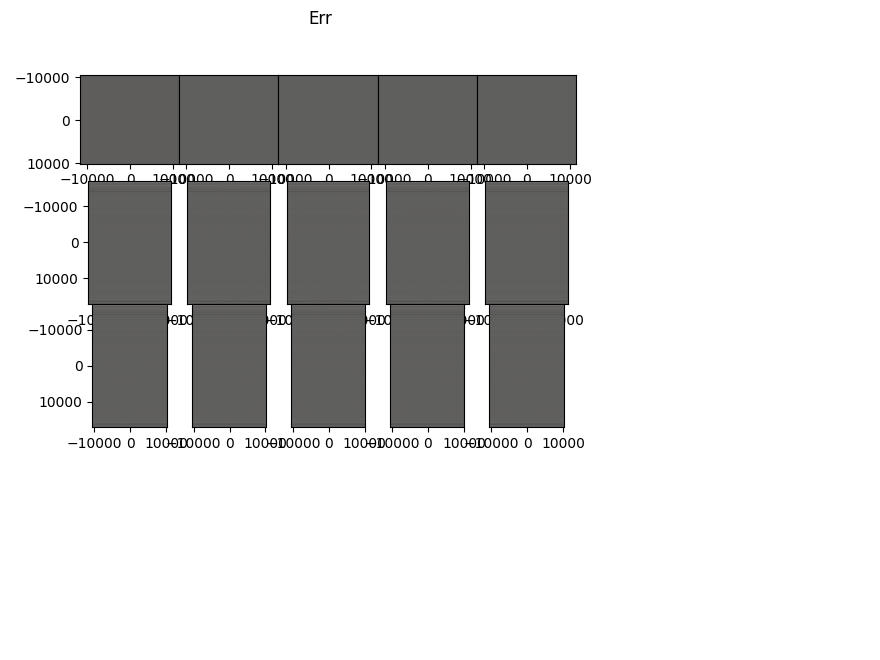

<IPython.core.display.Javascript object>


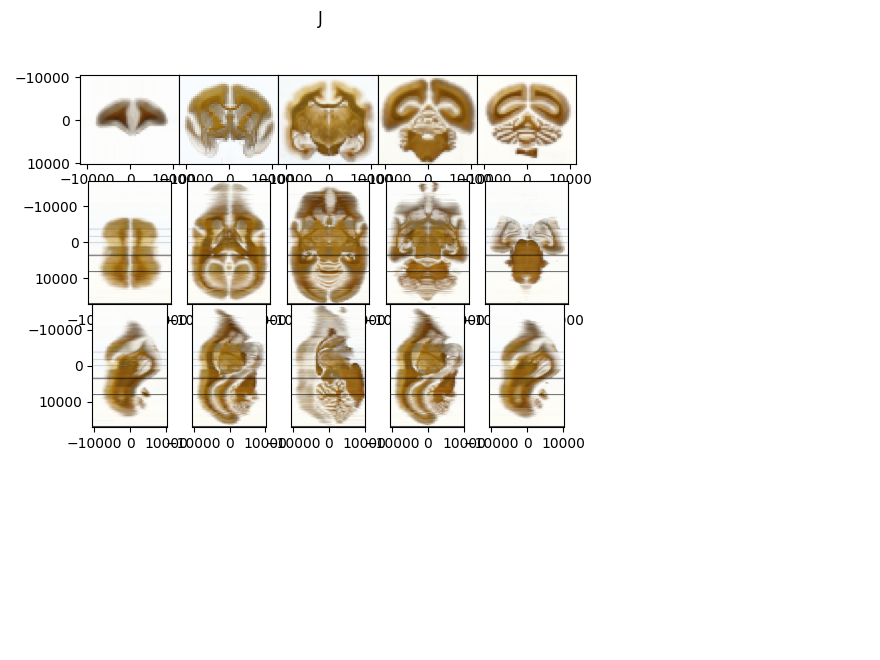

<IPython.core.display.Javascript object>


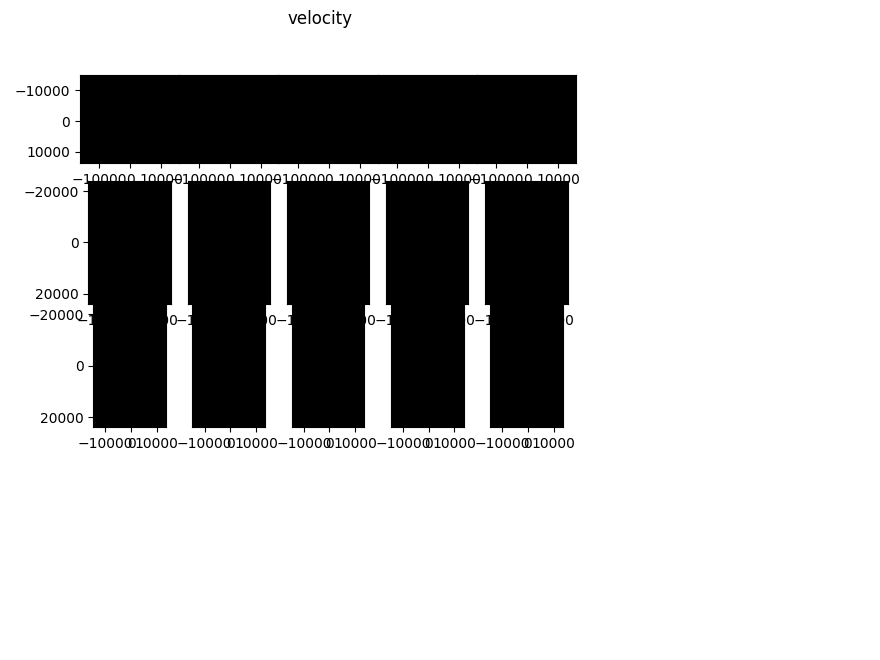

<IPython.core.display.Javascript object>


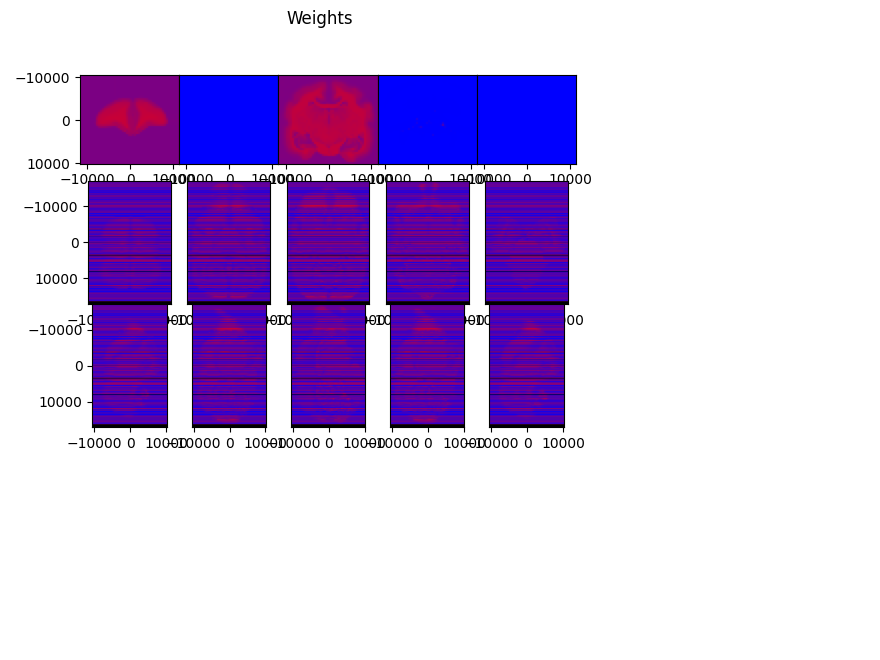

/home/brysongray/emlddmm/emlddmm.py:98: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


output dir is /home/brysongray/data/marmoset_ccf/nissl_to_myelin_outputs/
cpu


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
importlib.reload(emlddmm)
importlib.reload(tg)

output = reg_list[0]['output']

graph = tg.run_registrations(reg_list)
with open(os.path.join(output, 'graph.p'), 'wb') as f:
    pickle.dump(graph, f)

In [ ]:
space_image_path = [
    ['CCF','average_template_50', '/home/brysongray/data/MD816_mini/average_template_50.vtk'],
    ['HIST_MD816', 'nissl', '/home/brysongray/data/MD816_mini/MD816_STIF_mini_new'],
    ['MRI', 'masked', '/home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1_masked.vtk'],
    ['MRI', 'unmasked', '/home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1.vtk']
                   ]
# convert space_image_path to dictionary of dictionaries. (image_name:path key-values in a dict of space:img key-values)
sip = {} # space-image-path dictionary
for i in range(len(space_image_path)):
    if not space_image_path[i][0] in sip:
        sip[space_image_path[i][0]] = {}
    new_img = {space_image_path[i][1]: space_image_path[i][2]}
    sip[space_image_path[i][0]].update(new_img)

print(sip)

In [ ]:
importlib.reload(tg)
importlib.reload(emlddmm)

with open(os.path.join(output, 'graph.p'), 'rb') as f:
    graph = pickle.load(f)

# perform all reconstructions
for src_space in sip:
    for src_image in sip[src_space]:
        # reconstruct in every other space
        src_path = sip[src_space][src_image]
        I = emlddmm.Image(src_space, src_image, src_path, x=graph.spaces[src_space][1])
        for target_space in [n for n in sip if n != src_space]:
            target_image = list(sip[target_space].keys())[0]
            target_path = sip[target_space][target_image]
            if os.path.splitext(target_path)[-1] == '':
                fnames = emlddmm.fnames(target_path)
                tg.graph_reconstruct(graph, output, I, target_space, target_fnames=fnames)
            else:
                tg.graph_reconstruct(graph, output, I, target_space)